<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Изменение---добавил-КПСС-тест" data-toc-modified-id="Изменение---добавил-КПСС-тест-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изменение - добавил КПСС тест</a></span></li><li><span><a href="#Изменение---поправил-декомпозицию" data-toc-modified-id="Изменение---поправил-декомпозицию-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Изменение - поправил декомпозицию</a></span></li><li><span><a href="#Вопрос-по-функции-автокореляции-нестационарных-рядов" data-toc-modified-id="Вопрос-по-функции-автокореляции-нестационарных-рядов-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вопрос по функции автокореляции нестационарных рядов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
import timeit
from timeit import default_timer as timer
from statsmodels.tsa.stattools import kpss

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

def luk(data):
    print(data.info())
    print()
    print(data.duplicated().sum())
    print()
    print(data.nunique())
    print()
    print(data.isna().sum())
    print()
    print(data.head())
    print()
    print(data.sample(n=10, replace=True, random_state=42))
    print(data.describe())
    
luk(df)

У нас имеется переодичность количества заказов в 10 минут. Проверим данные на монотонность  выполним ресемплирование по одному часу

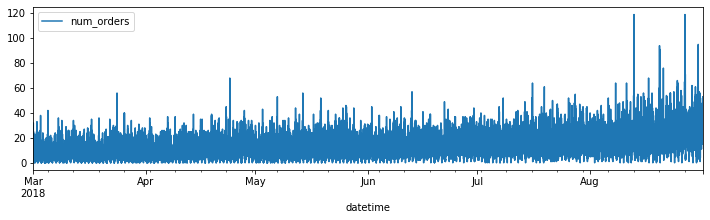

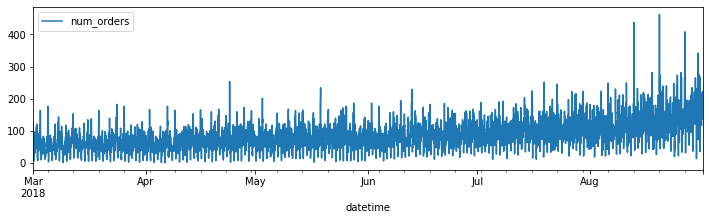

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', drop=True, inplace=True)
print('Порядок соблюден?')
print(df.index.is_monotonic)
print('###############################')
print(df.info())
df.plot(figsize = [12, 3])
df = df.resample('1H').sum()
df.plot(figsize = [12, 3])
print(df.info())
df_final = df.copy()

Таким образом, условия монотонности соблюдены и сортировка не требуется. Текущие данные включают в себя отрезок с 1 марта по 31 августа 2018 года.

## Анализ

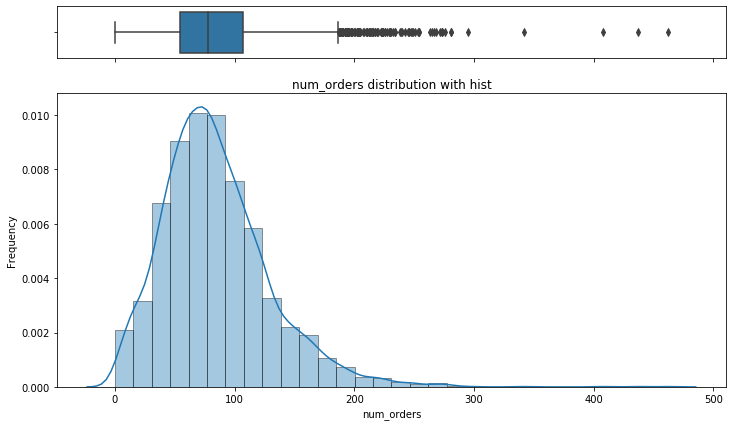

In [4]:
def plot_hist(data, column):

    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={'height_ratios': (.15, .85)},
                                        figsize=(12, 7))

    sns.distplot(data[column],
                 hist=True,
                 kde=True, 
                 bins=30,
                 hist_kws={'edgecolor':'black'})
    sns.boxplot(data[column],
                ax=ax_box) 

    ax_box.set(xlabel='')
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('{} distribution with hist'.format(column))
    
    plt.show()

plot_hist(df, 'num_orders')

In [5]:
def series_plot(data):
    
    data_local = data.copy()
    
    fig = go.Figure()
    
    for column in data_local.columns:
        
        fig.add_trace(go.Scatter(x=data_local.index,
                                 y=data_local[column],
                                 mode='lines',
                                 name=column))
    
    fig.update_layout(title='Time Series Plot',
                      xaxis_title='DateTime',
                      yaxis_title='Number of Orders')

    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

series_plot(df)

In [6]:
#Окно в 12 часов позволит посмотреть на разницу в дневное и ночное время суток
def rolling(data,window):
    data['rolling_mean'] = data.rolling(window).mean()
    data['rolling_std'] = data['num_orders'].rolling(window).std()
    return data

df_roll = rolling(df,12)
#df['rolling_mean'] = df.rolling(12).mean()
#df['rolling_std'] = df['num_orders'].rolling(12).std()

In [7]:
series_plot(df)

Приведенные графики позволяют нам говорить о том, что перед нами нестационарный процесс , т.к распределение меняется.

### Изменение - добавил КПСС тест

In [8]:
#Подтвердим свои выводы KPSS тестом на стационарность и стационарность вокруг тренда.
#https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/

series = df.loc[:, 'num_orders'].values
# KPSS тест

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Вывод результатов
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(series)
print()
kpss_test(series,regression='ct')

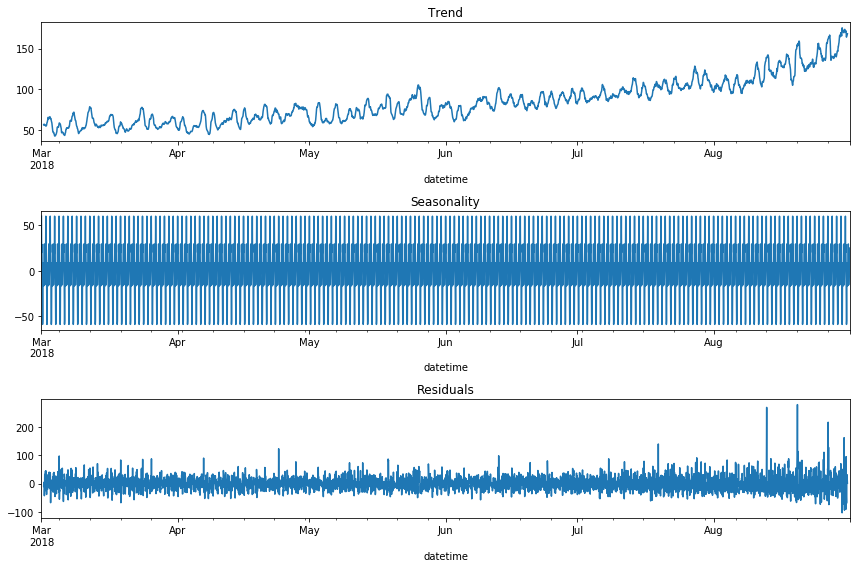

In [9]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

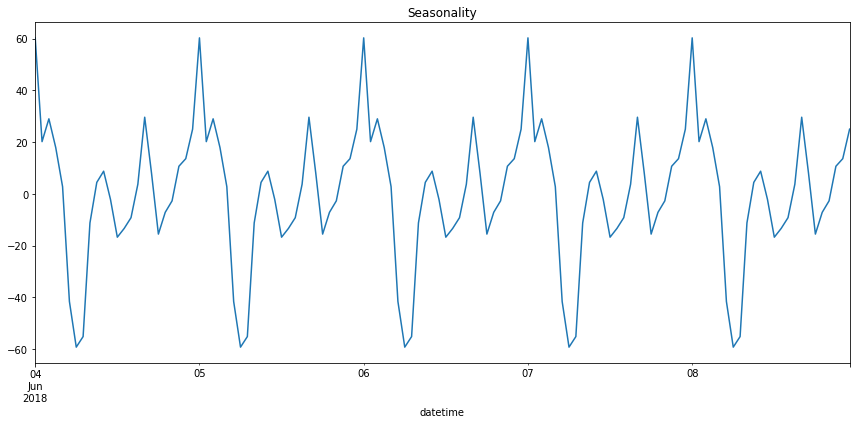

In [10]:
#decomposed = seasonal_decompose(df.loc['2018-06-04':'2018-06-08', 'num_orders'])
plt.figure(figsize=(12, 6))

decomposed.seasonal['2018-06-04':'2018-06-08'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Тренд указывает на постепенный рост числа заказов в течение года. Сезонность, отчетлево проявляется в течение времени дня. Так заметно повышение спроса в 00:00 и в тоже время имеется резкое падение в области 06:00. Остатки же - это не интепритируемая величина.

In [11]:
# Воспользуемся советами статьи 
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
# Ребята предлагают представлять временые ряды как базовые признаки
# То есть колонку с датой можно представить как несколько колонок с категориальными признакми, как Год/Месяц/...
# Напишем функцию автоматизации этого процесса

def datetocat(data): 
    data['month'] = data.index.month 
    data['day'] = data.index.day
    data['dayofweek_num'] = data.index.dayofweek
    data['Hour'] = data.index.hour 
    data['minute'] = data.index.minute
    return data

datetocat(df)

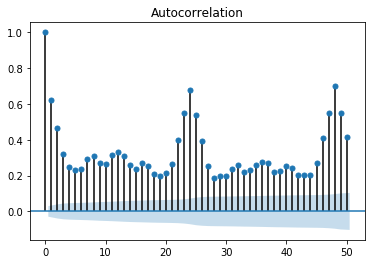

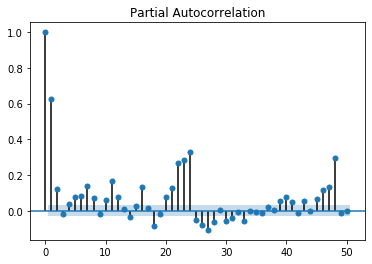

In [12]:
# Все в той же статье
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
# для определения сдвига предлагается использовать ACF (Autocorrelation Function)
# и PACF (Partial Autocorrelation Function)
# ACF: ACF мера коррелляции между самим временным рядом и его сдвиннутой версией
# PACF: мера коррелляции между самим временным рядом и его сдвиннутой версией, 
# но без вариантов которые уже были обьясненны промежуточными значениями
# используем максимальный лаг в 50 часов что бы увидеть зависимости в течении одних суток и чуть больше

plot_acf(df['num_orders'], lags=50);
plot_pacf(df['num_orders'], lags=50);

In [13]:
# Т.к. сильная кореляция наблюдается  в районе 1, 23, 24 и 25 часа пользуем их для сдвига
df['lag_1'] = df['num_orders'].shift(1)
df['lag_23'] = df['num_orders'].shift(23)
df['lag_24'] = df['num_orders'].shift(24)
df['lag_25'] = df['num_orders'].shift(25)

In [14]:
# Все в той же статье
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
# предлагается чуть более продвинутая версия скользящего среднего - расширяющееся окно
# В случае скользящего размер окна постоянен, 
# в то время как окно скользит по мере продвижения вперед во времени. 
# Следовательно, мы рассматриваем только самые последние значения и игнорируем прошлые значения.
# Идея расширяющегося окна заключается в том, что она учитывает все прошлые значения.

def expanding(data,window):
    data['expanding_mean'] = data['lag_1'].expanding(window).mean()
    data['expanding_std'] = data['lag_1'].expanding(window).std()
    return data

df_final = expanding(df_roll,2)


#df['expanding_mean'] = df['lag_1'].expanding(2).mean()
#df['expanding_std'] = df['lag_1'].expanding(2).std()
series_plot(df[['rolling_mean', 'rolling_std', 'expanding_mean', 'expanding_std']])

## Обучение

In [15]:
# Подготовим выборки
# Масштабируем признаки
# Сделаем это функцией

scores_data = pd.DataFrame()

#train, test = train_test_split(df, shuffle=False, test_size=.1)
train, test = train_test_split(df_final, shuffle=False, test_size=.1)
train = train.dropna()

def preparation(data, point):
    
    
    train, valid = train_test_split(data, test_size=.25, shuffle=False)
    
    
    def features_target_split(data1, point):
        features = data1.drop([point], axis=1)
        target = data1[point]
        return features, target

    train_features, train_target = features_target_split(train, point)
    valid_features, valid_target = features_target_split(valid, point)
    
    def data_to_StandardScaler(data2, train_features):
        scaler = StandardScaler()
        scaler.fit(train_features)
        data3 = scaler.transform(data2)
        return data3
    
    valid_features = data_to_StandardScaler(valid_features, train_features)
    train_features = data_to_StandardScaler(train_features, train_features)
    
    return valid_features, train_features, train_target, valid_target


#Подготовим код метрики

def rmse(predict, target):
    mse = mean_squared_error(target, predict)
    rmse = mse ** 0.5
    return rmse
    
score = make_scorer(rmse, greater_is_better=False)

(valid_features, train_features,
 train_target, valid_target) = preparation(train, 'num_orders')

In [16]:
#Функция, которая будет производить поиск наилучшего сочетания гиперпараметров модели по сетке.

def model_search(model, parameters): 
    splits = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model,
                        parameters,
                        cv=splits,
                        scoring=score,
                        n_jobs=-1)
    grid.fit(train_features, train_target)
    predictions = grid.predict(valid_features) 
    best_parameters = grid.best_params_
    best_score_RMSE = round(rmse(predictions, valid_target), 2)
    print('')
    print('Итоги обучения модели:')
    print('')
    print('- Лучшее сочетание гиперпараметров: \n  {}'.format(best_parameters))
    print('')
    print('- RMSE: {}'.format(best_score_RMSE))
    print('')
    
    grid_plot(valid_target, predictions)
    
    return best_score_RMSE, best_parameters

#Функция для визуализации итогов работы алгоритма.

def grid_plot(valid_target, predictions):
    
    f, ax = plt.subplots(1, 2, figsize=(15, 6))
        
    lims = [0, valid_target.max()]

    ax[0].set_title('Errors estimation')
    sns.scatterplot(valid_target,
                    predictions,
                    alpha=.4,
                    ax=ax[0])
    sns.lineplot(lims,
                 lims,
                 color='red',
                 linewidth=2.5,
                 ax=ax[0]).lines[0].set_linestyle('--')
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted')
    
    error = predictions - valid_target
    
    ax[1].set_title('Errors distribution')
    sns.distplot(error,
                 hist=True,
                 kde=True, 
                 bins=50,
                 hist_kws={'edgecolor':'black'},
                 ax=ax[1])
    ax[1].set_xlabel('Prediction Error')
    ax[1].set_ylabel('Frequency')
    
    plt.show()
    
    target = pd.DataFrame(valid_target)
    pred = pd.DataFrame(predictions)
    pred.index = target.index
    df_plot = target.merge(pred, left_index=True, right_index=True)
    df_plot.columns = ['Actual', 'Predicted']
    
    series_plot(df_plot)

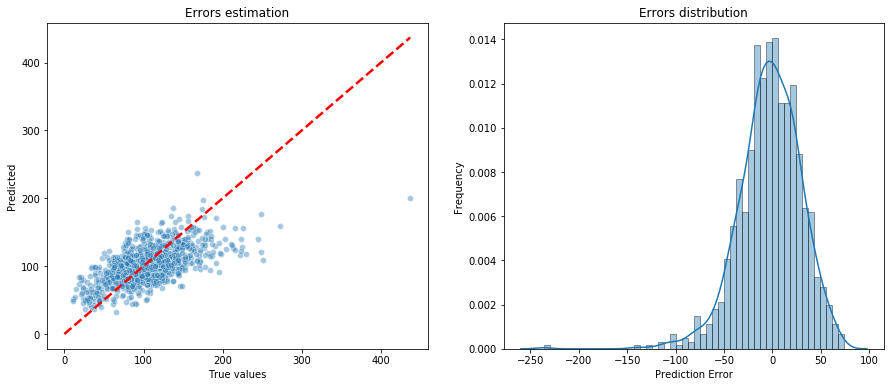

In [17]:
lin_reg = LinearRegression()
param_lr = {'fit_intercept':[True, False],
            'normalize':[True, False],
            'copy_X':[True, False]}

start_time = timer()

lin_reg_RMSE, lin_reg_best_parameters = model_search(lin_reg, param_lr)

lin_reg_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(lin_reg_time))

scores_data = scores_data.append({'Regressor':'LinearRegression', 
                                  'RMSE':lin_reg_RMSE,
                                  'Time':lin_reg_time,
                                 }, ignore_index=True)

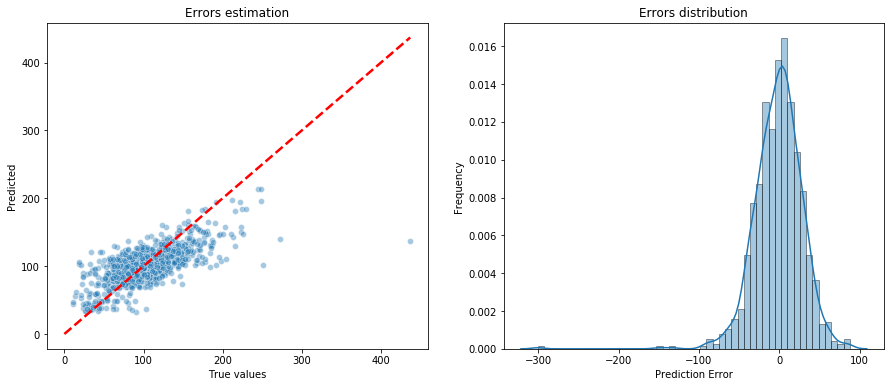

In [18]:
forest = RandomForestRegressor(random_state=42)
param_forest = {'n_estimators':[100, 200, 300],
                'max_depth':[10, 20, 30, 40, 50],
                'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10],
                'max_features': ['auto', 'sqrt'],
                'bootstrap': [True]}

start_time = timer()

forest_RMSE, forest_best_parameters = model_search(forest, param_forest)

forest_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(forest_time))

scores_data = scores_data.append({'Regressor':'RandomForestRegressor', 
                                  'RMSE':forest_RMSE,
                                  'Time':forest_time,
                                 }, ignore_index=True)

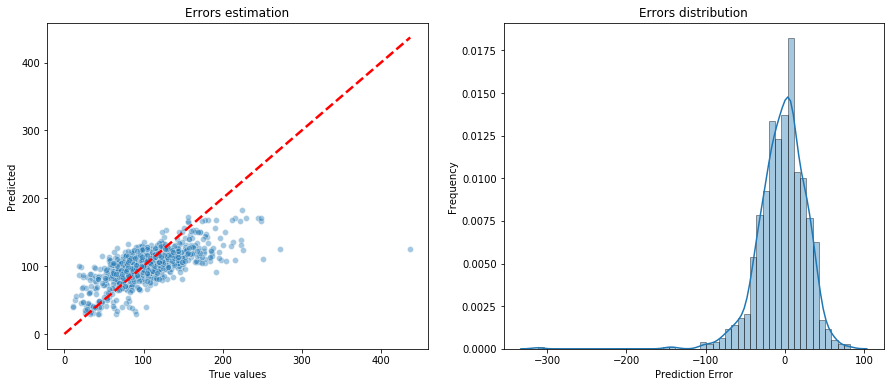

In [19]:
lgbm = LGBMRegressor(random_state=42, silent=True)
params_lgbm = {'learning_rate':[1e-2, 1e-3, 1e-4, 1e-5],
               'n_estimators':[100, 200, 300],
               'num_leaves':[20, 30, 40, 50],
               'boosting_type':['gbdt', 'goss']}

start_time = timer()

lgbm_RMSE, lgbm_best_parameters = model_search(lgbm, params_lgbm)

lgbm_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(lgbm_time))

scores_data = scores_data.append({'Regressor':'LGBMRegressor', 
                                  'RMSE':lgbm_RMSE,
                                  'Time':lgbm_time,
                                 }, ignore_index=True)

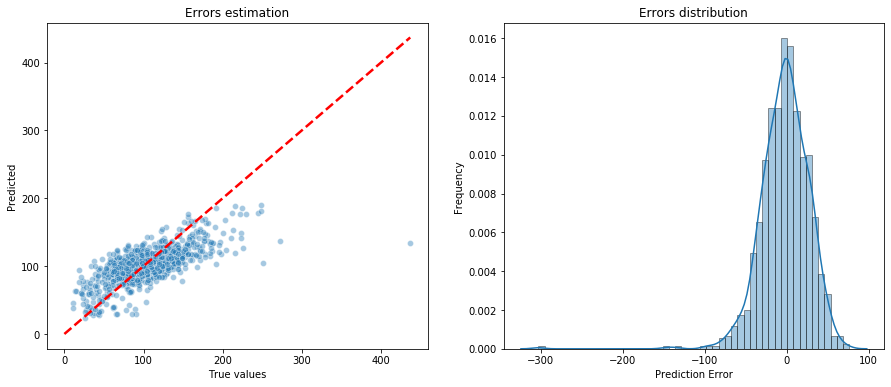

In [20]:
cat = CatBoostRegressor(random_state=42, silent=True)
params_cat = {'max_depth': [2, 4, 6],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [50, 100, 200]}

start_time = timer()

cat_RMSE, cat_best_parameters = model_search(cat, params_cat)

cat_time = timer() - start_time
print("Время обучения модели: {:f} секунд".format(cat_time))

scores_data = scores_data.append({'Regressor':'CatBoostRegressor', 
                                  'RMSE':cat_RMSE,
                                  'Time':cat_time,
                                 }, ignore_index=True)

In [21]:
scores_data = scores_data.set_index('Regressor')
scores_data.sort_values(by='RMSE')

Таким образом, лучше всего себя показала модель CatBoostRegressor. Значение метрики **RMSE** для оной составило **29.18**. И скорость была самой высокой

## Тестирование

In [22]:
def model_final(model):
    
    train_features = train.drop(['num_orders'], axis=1)
    train_target = train['num_orders']
    test_features = test.drop(['num_orders'], axis=1)
    test_target = test['num_orders']
                             
    model.fit(train_features, train_target)
    predictions = model.predict(test_features)
    
    best_score_RMSE = round(rmse(predictions, test_target), 2)
 
    importances= model.feature_importances_
    feature_names = test_features.columns                 
    model_importances = pd.Series(importances, index=feature_names)
    
    print('')
    print('Итоги обучения модели:')
    print('')
    print('- RMSE: {}'.format(best_score_RMSE))
    print('')
    print('Факторы моделирования: \n{}'.format(model_importances))
    
    grid_plot(test_target, predictions)
    
    feature_importans_plot(model_importances)

In [23]:
def feature_importans_plot(model_importances):
    
    f, ax = plt.subplots(figsize=(12, 7))
    
    ax.bar(x=model_importances.index, height=model_importances.values)
    ax.set_title('Feature importances plot')
    ax.set_ylabel('Coefficients')
    plt.xticks(rotation = 90)
    f.tight_layout()
    
    plt.show()

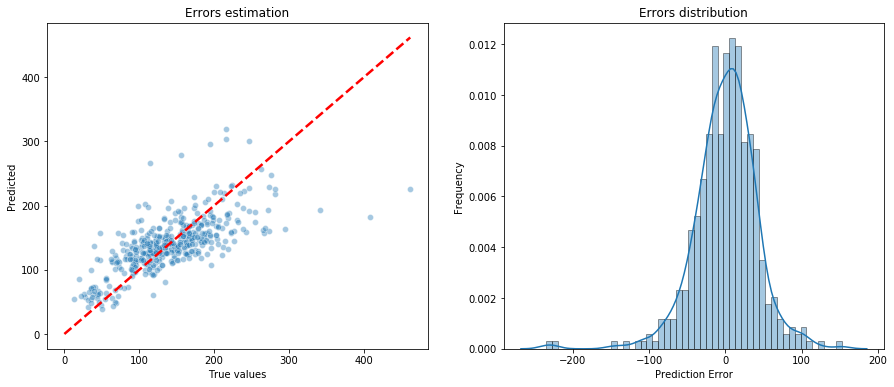

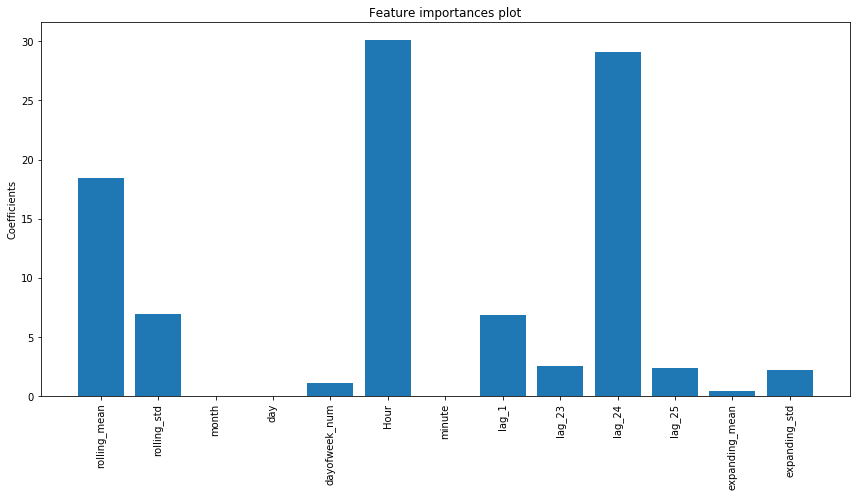

In [24]:
model_test = CatBoostRegressor(random_state=42, silent=True, **cat_best_parameters)

model_final(model_test)

## Вывод

Итак, исходные полученные данные не содержали пропусков или аномалий в явном виде, соответственно не требовали предобработки по данным направлениям.

Однако, ввиду того, что число заказов - `num_orders` считывалось с шагов в **10 минут**, было решено провести **ресемплинг** по одному часу для сглаживая временного ряда. Далее были введены **скользящее среднее** и **стандартное отклонение** с окном в **12 часов**, что с учетом ресемплинга позволило учитывать значения в дневное и ночное время суток. Затем мы проанализировали **тренд** и **сезонность** нашего временного ряда. По итогам данного анализа было выявлено, что тренд в явном виде указывает на *постепенно увеличивающиеся число заказом* в рамках представленного временного промежутка. Сезонность отчетливо проявляется в рамках *двадцатичетырехчасового цикла* с повышенным числом заказов в области **00:00** и противоположной ситуацией в районе **06:00**. Предложу, внести динамичное изменение цен на предоставляемые услуги в соответствие с выявленными закономерности.

На следующем этапе были добавлены несколько новых признаков:

   - указатели даты подсчета числа заказов;
   - признаки на основе отстающих значений; 
   - признаки расширяющего окна;
   
Было протестировано несколько моделей на основе метода оптимизации **GridSearchCV**. По итогам данной проверки лучшего всего на валидационной выборке себя показала модель **CatBoostRegressor** с показателем метрики $RMSE$ равным **29.18**. На тестовой выборке, равной **10%** от исходного датафрейма, данная модель дала значение метрики в **41.41**.